In [6]:
#TODO: load dependencies from file

In [336]:
#!pip install pymystem3

In [7]:
import os
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pymorphy2
import gensim
import stop_words
from nltk.stem.snowball import RussianStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import json
import string
import copy
import gensim
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel

%matplotlib inline

In [20]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [125]:
news = []
with open('corpus.json', 'r', encoding="utf-8") as file:
    text = file.read()
    dct = json.loads(text)
data = pd.DataFrame(dct['catalog'])
data.head()

,article_id,category,title,text,tags
0,https://www.nn.ru/text/auto/2022/01/12/70369148/,auto,Кризис ОСАГО залатали рублем. Полисы резко под...,ОСАГО сильно прибавило для неблагополучных вод...,"[ОСАГО, автозакон, страховка]"
1,https://www.nn.ru/text/auto/2022/01/11/70366607/,auto,Я пропустил техосмотр в 2021 году. Оштрафуют л...,Обязательный техосмотр для частных машин отмен...,"[автозакон, техосмотр, автоликбез]"
2,https://www.nn.ru/text/auto/2022/01/08/70343681/,auto,Цены отмороженные: как кризис автомобильных пр...,Автомобили снова стали для большинства из нас ...,"[автопром, авторынок, цены на авто]"
3,https://www.nn.ru/text/auto/2022/01/07/70350704/,auto,"Новые Vesta и Logan, пятый Sportage и много «к...",Главная премьера начала года — новый KIA Sport...,"[автопром, авторынок, цены на авто]"
4,https://www.nn.ru/text/auto/2022/01/04/70343603/,auto,Бензин по 50 рублей — это лишь начало. Что жде...,Топливо дорожало весь прошлый год и установило...,"[АЗС, бензин, топливо, цены на топливо]"


In [127]:
data.text

0       ОСАГО сильно прибавило для неблагополучных вод...
1       Обязательный техосмотр для частных машин отмен...
2       Автомобили снова стали для большинства из нас ...
3       Главная премьера начала года — новый KIA Sport...
4       Топливо дорожало весь прошлый год и установило...
                              ...                        
4094    Поделиться   Предсказать массовые сокращения с...
4095    Поделиться   NN.RU: Трудоустройство инвалидов ...
4096    Поделиться   Эксперты МОТ обосновали предложен...
4097    commons.wikimedia.org   Поделиться   \- В Росс...
4098    Сбербанк   Поделиться   Сбербанк предлагает то...
Name: text, Length: 4099, dtype: object

In [128]:
data.category.unique()

array(['auto', 'gorod', 'health', 'job'], dtype=object)

In [129]:
labels = {'auto':0, 'gorod':1, 'health':2, 'job':3}

In [130]:
for cat in labels.keys():
    print(f'{data[data.category == cat].count()[0]} новостей в категории {cat}')

1036 новостей в категории auto
1024 новостей в категории gorod
1032 новостей в категории health
1007 новостей в категории job


In [133]:
corpus = [doc for doc in data.text]
all_tags = [' '.join(tags) for tags in data.tags]
categories = data.category.to_list()

## Препроцессинг

In [134]:
corpus = np.asarray([doc.replace('Поделиться', '') for doc in corpus])
print(len(corpus))

4099


In [135]:
def remove_extra_characters(list_of_texts):
    EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

    GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

    regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
    regex_dig = re.compile('[%s]' % re.escape(string.digits))
    regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
    regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
    emoji_pattern = re.compile("["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+")
    
    list_of_texts = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in list_of_texts]
    list_of_texts = [re.sub(' +' , ' ', doc) for doc in list_of_texts]
    list_of_texts = np.asarray([doc.strip().strip('\t').replace('\n', u'')    for doc in list_of_texts])
    list_of_texts = [regex_punct.sub('', doc) for doc in list_of_texts]
    list_of_texts = [regex_dig.sub('', doc) for doc in list_of_texts]
    list_of_texts = [regex_symb.sub(' ', doc) for doc in list_of_texts]
    list_of_texts = [regex_struct.sub('', doc) for doc in list_of_texts]
    list_of_texts = [re.sub(' +' , ' ', doc.strip()) for doc in list_of_texts]
    list_of_texts = [doc.lower() for doc in list_of_texts]
    list_of_texts = [emoji_pattern.sub('', doc) for doc in list_of_texts]
    return list_of_texts

In [136]:
tags = remove_extra_characters(all_tags)
corpus = remove_extra_characters(corpus)

In [137]:
corpus[:2]

['осаго сильно прибавило для неблагополучных водителей а также молодежи таксистов и коммерсантов фото читатель ru в январе го банк россии существенно изменил ставки осаго причем для ряда категорий страховка подорожает а для других станет дешевле мы детально изучили постановление центробанка и заметили четкую тенденцию автогражданка стала накладнее ровно для тех автомобилистов которым страховые чаще всего отказывали в продаже полисов в прошлом году подробнее об изменениях в нашем материале как рассчитывается осаго страховщики выбирают базовый тариф в указанных банком россии пределах и умножают на коэффициентов которые учитывают мощность двигателя период использования машины аварийность водителя коэффициент бонусмалус возраст и стаж водителя территорию использования срок страхования и наличие грубых нарушений последний коэффициент зависит не от штрафов гибдд но от нарушений правил страхования тарифный коридор снова расширили диапазон базовой ставки в очередной раз увеличили если в начале

In [138]:
tags[:10]

['осаго автозакон страховка',
 'автозакон техосмотр автоликбез',
 'автопром авторынок цены на авто',
 'автопром авторынок цены на авто',
 'азс бензин топливо цены на топливо',
 'коап осаго автозакон медсправка страховка электромобили',
 'гибдд госуслуги',
 'коап ук рф автозакон автоликбез',
 'альфастрахование банк россии осаго центробанк страховка',
 'авто техосмотр']

In [139]:
morph = pymorphy2.MorphAnalyzer()

corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
        
print(len(corpus_tokens))

C:\Users\Anton Musatov\AppData\Local\Programs\Python\Python36\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Anton Musatov\AppData\Local\Programs\Python\Python36\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Anton Musatov\AppData\Local\Programs\Python\Python36\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Anton Musatov\AppData\Local\Programs\Python\Python36\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecat

4095


In [140]:
inds_to_drop

[3281, 3308, 3433, 3529]

In [141]:
corpus = np.asarray(corpus)
labels = np.asarray(labels)
tags = np.asarray([tag_list.split(' ') for tag_list in tags])

corpus = np.delete(corpus, inds_to_drop)
categories = np.delete(categories, inds_to_drop)
tags = np.delete(tags, inds_to_drop)

In [148]:
tags = np.asarray(tags)

In [151]:
stemmer = RussianStemmer()

corpus_tokens_stem = []
tags_stem = []

for i in range(len(corpus_tokens)):
    tmp_tokens = corpus_tokens[i]
    tmp_tags = tags[i]
    
    corpus_tokens_stem.append([stemmer.stem(word) for word in tmp_tokens])
    tags_stem.append([stemmer.stem(tag) for tag in tmp_tags])
    
print(len(corpus_tokens_stem))
print(len(tags_stem))

4095
4095


In [152]:
tmp_corp = []

for i, tokens in enumerate(log_progress(corpus_tokens_stem[:])):
    tmp_corp.append([t for t in tokens if len(t) > 2])

result_corpus_tokens = tmp_corp

In [153]:
len(result_corpus_tokens)

4095

In [154]:
vocab = np.unique(np.concatenate(result_corpus_tokens).flatten()).tolist()
print(f'Количество токенов в словаре: {len(vocab)}')
print('Первые 10 слов в словаре:')
vocab[:10]

Количество токенов в словаре: 33729
Первые 10 слов в словаре:


['абака',
 'абакан',
 'абакум',
 'абакумов',
 'аббревиатур',
 'абвер',
 'абдоминальн',
 'абдулкерим',
 'аберрац',
 'абзац']

**Над новостным корпусом и тэгами был произведен стандартный препроцессинг и стемминг.**

In [155]:
clean_text = copy.deepcopy(result_corpus_tokens)

**Добавим к нашему датасету би-граммы и три-граммы.**

In [40]:
bigram = Phrases(clean_text)
trigram = Phrases(bigram[clean_text])

for idx in range(len(clean_text)):
    for token in bigram[clean_text[idx]]:
        if '_' in token:
            clean_text[idx].append(token)
    for token in trigram[clean_text[idx]]:
        if '_' in token:
            clean_text[idx].append(token)

**Пример полученных словосочетаний**

In [41]:
clean_text[1][-10:-1]

['административн_правонарушен',
 'част_стат_коап_наказыва',
 'езд_техосмотр',
 'уголовн_ответствен',
 'выезд_встречн',
 'превышен_скорост',
 'нов_коап',
 'штраф_езд',
 'оформлен_полис']

**Теперь преобразуем новостной копрус в словарь частот, который можно подать на вход алгоритму LDA**

In [42]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=10, no_above=0.1)

corpus1 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus1))

Количество уникальных токенов: 12085
Количество документов: 4095


## Модель LDA

Натренируем модель LDA, которая будет выделять 4 темы.

In [43]:
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

ldamodel = LdaModel(corpus=corpus1, num_topics=4, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

In [65]:
ldamodel.show_topics()

[(0,
  '0.006*"штраф" + 0.004*"штраф_рубл" + 0.003*"дтп" + 0.003*"лишен_свобод" + 0.003*"транспортн_средств" + 0.003*"российск_федерац" + 0.003*"пункт" + 0.003*"причин_отказ" + 0.003*"знак" + 0.003*"ответствен"'),
 (1,
  '0.008*"рабоч_мест" + 0.006*"трудов" + 0.005*"заработн_плат" + 0.005*"занят" + 0.005*"ваканс" + 0.004*"заработн" + 0.004*"предприят" + 0.004*"служб_занят" + 0.004*"центр_занят" + 0.004*"кандидат"'),
 (2,
  '0.006*"фот_арт" + 0.004*"вакцин" + 0.002*"прививк" + 0.002*"препарат" + 0.002*"вирус" + 0.002*"арт" + 0.002*"лечен" + 0.002*"модел" + 0.002*"женщин" + 0.002*"тест"'),
 (3,
  '0.003*"социальн_сет" + 0.003*"праздник" + 0.003*"экскурс" + 0.003*"выходн" + 0.003*"новогодн" + 0.002*"подростк" + 0.002*"дед_мороз" + 0.002*"школ" + 0.002*"администрац" + 0.002*"парк"')]

Как мы помним, в новостном корпусе представлены 4 темы:
- город
- автомобили
- здоровье
- работа

Из распределения ключевых слов внутри каждой темы можно сделать вывод, что модель выделила темы в соотвествии с изначальным набором категорий новостей.
- 1 тема = автомобили (штраф, дтп, знак, транспортное средство)
- 2 тема = работа (рабочее место, трудовой, заработная плата)
- 3 тема = здоровье (вакцина, привика, препарат)
- 4 тема = город (праздник, экскурсия, администрация, парк)

**Визуализация**

In [105]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus1, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.060599  0.068465       1        1  48.992333
3     -0.209090 -0.116251       2        1  20.740216
0      0.060794  0.203514       3        1  17.581237
1      0.208894 -0.155728       4        1  12.686214, topic_info=             Term         Freq        Total Category  logprob  loglift
7125   рабоч_мест   943.000000   943.000000  Default  30.0000  30.0000
249         штраф  1071.000000  1071.000000  Default  29.0000  29.0000
10635      вакцин  2100.000000  2100.000000  Default  28.0000  28.0000
436        трудов  1057.000000  1057.000000  Default  27.0000  27.0000
453       фот_арт  2950.000000  2950.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4129      населен   433.182399   859.868792   Topic4  -5.6606   1.3790
6695      професс   345.840834   751.151108   Topic4  -5.8858   1.2890
289      деятельн   302.671117   471.442665   Topic4  -6.0192   1.6215
708        реальн   310.046548   561.959757   Topic4  -5.9951   1.4699
402        размер   324.213984   845.602105   Topic4  -5.9504   1.1060

[261 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
0         1  0.030411               авар
0         3  0.968076               авар
6700      2  0.992889  автозаводск_район
6700      3  0.003804  автозаводск_район
5         1  0.035727       автомобилист
...     ...       ...                ...
7846      2  0.989290            экскурс
252       1  0.184550              январ
252       2  0.558078              январ
252       3  0.069391              январ
252       4  0.188979              январ

[438 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

**Качетство модели можно измерить с помощью когерентности.**

In [305]:
def compute_coherence(ldamodel, dictionary):
    return CoherenceModel(model=ldamodel, texts=clean_text, dictionary=dictionary, coherence='c_v').get_coherence()

In [58]:
coherencemodel.get_coherence()

0.40896733473098773

Когерентность нашей модели: 0.4

**Введем свою собственную метрику измерения качества, основанную на тэгах**

Из новостного корпуса выберем 4 текста из разных категорий.
Для каждого из них проделаем следующее:
1. С помощью нашей модели получим тему, вероятность которой наибольшая.
2. Выберем 5 ключевых слов этой темы.
3. Вычислим "похожесть" тэгов, соотвествующих новости, и ключевых слов темы. (сравниваем каждый тэг с каждым ключевым словом и берем среднее)

Метрика качества модели - среднее по значениям "похожести" тэгов и ключевых слов.

In [276]:
texts_for_test = [1, 2300, 500, 2800]

In [280]:
print('Тэги для выбранных новостей')
for m in texts_for_test:
    print(tags_stem[m])

Тэги для выбранных новостей
['автозакон', 'техосмотр', 'автоликбез']
['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
['групп', 'разбор', 'дтп', 'закон', 'ликбез']
['бол', 'лечен', 'медицин']


In [222]:
import gensim.downloader as api

model = api.load("word2vec-ruscorpora-300")
for word, distance in model.most_similar("страховка_NOUN"):  
    print(u"{}: {:.3f}".format(word, distance))

страховать_VERB: 0.634
автогражданский::ответственность_NOUN: 0.578
страховочный_ADJ: 0.566
бенефит_NOUN: 0.564
страховой::полис_NOUN: 0.540
полис::дмс_NOUN: 0.539
страховаться_VERB: 0.536
спасработа_NOUN: 0.516
полис::осаго_NOUN: 0.502
медстрахование_NOUN: 0.492


In [291]:
m= Mystem()

In [292]:
def tag(word='пожар'):
    global m
    
    rnc_to_upos_tag = {
    "A":"ADJ",
    "ADV":"ADV",
    "ADVPRO":"ADV",
    "ANUM":"ADJ",
    "APRO":"DET",
    "COM":"ADJ",
    "CONJ":"SCONJ",
    "INTJ":"INTJ",
    "NONLEX":"X",
    "NUM":"NUM",
    "PART":"PART",
    "PR":"ADP",
    "S":"NOUN",
    "SPRO":"PRON",
    "UNKN":"X",
    "V":"VERB"
}
    
   
    processed = m.analyze(word)[0]
    if "analysis" not in processed or len(processed["analysis"]) == 0:
        return None
    lemma = processed["analysis"][0]["lex"].lower().strip()
    pos = processed["analysis"][0]["gr"].split(',')[0]
    pos = rnc_to_upos_tag[pos.split('=')[0].strip()]
    tagged = lemma+'_'+pos
    return tagged

In [293]:
def get_most_relevant_topic_for_document(model, document):
    return max(model.get_document_topics(document), key= lambda x: x[1])

In [294]:
def get_key_words_for_topic(model, topic, num=5):
    return [term[0] for term in model.show_topic(topic, topn=num)]

In [295]:
def compute_similarity(first, second):
    try: 
        return model.similarity(first, second)
    except Exception:
        return 0

In [296]:
results = []
for i in texts_for_test:
    topic = get_most_relevant_topic_for_document(ldamodel, corpus1[i])
    key_words = get_key_words_for_topic(ldamodel, topic[0])
    relevant_tags = tags_stem[i]
    print("Самая релевантная тема для текста:", topic[0], f"(вероятность {topic[1]})")
    print("Набор тэгов для текста", relevant_tags)
    print("Ключевые слова данной темы:", key_words)

    avg_metric = 0
    similarities = []
    for k in range(len(relevant_tags)):
        tagged_first = tag(relevant_tags[k])
        if not tagged_first:
            continue
        for j in range(len(key_words)):
            tagged_second = tag(key_words[j])
            if not tagged_second:
                continue
            similarities.append(compute_similarity(tagged_first,tagged_second))
    result = sum(similarities)/len(similarities)
    print('Метрика похожести с тэгами:', result)
    print()
    results.append(result)
print("Итог:", sum(results)/4)

In [297]:
get_custom_metric()

Самая релевантная тема для текста: 0 (вероятность 0.9821546673774719)
Набор тэгов для текста ['автозакон', 'техосмотр', 'автоликбез']
Ключевые слова данной темы: ['штраф', 'штраф_рубл', 'дтп', 'лишен_свобод', 'транспортн_средств']
Метрика похожести с тэгами: 0.07113202412923177

Самая релевантная тема для текста: 3 (вероятность 0.9986445903778076)
Набор тэгов для текста ['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
Ключевые слова данной темы: ['социальн_сет', 'праздник', 'экскурс', 'выходн', 'новогодн']
Метрика похожести с тэгами: 0.02984978910535574

Самая релевантная тема для текста: 0 (вероятность 0.9993573427200317)
Набор тэгов для текста ['групп', 'разбор', 'дтп', 'закон', 'ликбез']
Ключевые слова данной темы: ['штраф', 'штраф_рубл', 'дтп', 'лишен_свобод', 'транспортн_средств']
Метрика похожести с тэгами: 0.15751366853713988

Самая релевантная тема для текста: 2 (вероятность 0.9991933107376099)
Набор тэгов для текста ['б

## Еще несколько LDA моделей

Используем другие параметры для модели и посмотрим на результаты.

In [302]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus2 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus2))

Количество уникальных токенов: 5742
Количество документов: 4095


In [303]:
chunksize = 1000
passes = 20
iterations = 500
eval_every = None

ldamodel = LdaModel(corpus=corpus2, num_topics=4, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

In [311]:
ldamodel.show_topics()

[(0,
  '0.012*"автомобил" + 0.011*"машин" + 0.010*"рубл" + 0.009*"водител" + 0.007*"цен" + 0.007*"нов" + 0.006*"дорог" + 0.006*"например" + 0.004*"модел" + 0.004*"сто"'),
 (1,
  '0.007*"врач" + 0.005*"коронавирус" + 0.005*"пациент" + 0.005*"вакцин" + 0.005*"случа" + 0.004*"люд" + 0.004*"вакцинац" + 0.004*"говор" + 0.004*"дела" + 0.004*"нов"'),
 (2,
  '0.020*"работ" + 0.009*"компан" + 0.009*"работодател" + 0.008*"работа" + 0.008*"рубл" + 0.007*"работник" + 0.007*"сотрудник" + 0.006*"рабоч" + 0.006*"зарплат" + 0.006*"труд"'),
 (3,
  '0.017*"нижегородск" + 0.014*"натал" + 0.013*"нижн" + 0.013*"област" + 0.012*"бурухин" + 0.011*"город" + 0.011*"новгород" + 0.008*"район" + 0.007*"регион" + 0.007*"улиц"')]

In [304]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus2, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.072288  0.052637       1        1  35.480750
0      0.120588  0.090612       2        1  24.702456
2      0.026420 -0.187801       3        1  20.489132
3     -0.219296  0.044552       4        1  19.327663, topic_info=              Term         Freq        Total Category  logprob  loglift
1863   нижегородск  3629.000000  3629.000000  Default  30.0000  30.0000
433          работ  6636.000000  6636.000000  Default  29.0000  29.0000
2201         натал  2943.000000  2943.000000  Default  28.0000  28.0000
4        автомобил  3022.000000  3022.000000  Default  27.0000  27.0000
104          машин  2965.000000  2965.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
588            лет   572.837318   902.860031   Topic4  -5.8685   1.1887
1220        проект   617.884130  1205.297622   Topic4  -5.7928   0.9755
1048  правительств   546.352350   796.643900   Topic4  -5.9159   1.2665
1177     организац   581.336019  1406.596620   Topic4  -5.8538   0.7600
14           больш   573.224040  2296.704518   Topic4  -5.8679   0.2557

[300 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.004053         авар
0         2  0.988998         авар
0         4  0.006080         авар
494       2  0.995849          авт
495       2  0.996216      автоваз
...     ...       ...          ...
487       1  0.005983  экономическ
487       2  0.002991  экономическ
487       3  0.975158  экономическ
487       4  0.017948  экономическ
5408      4  0.995463       ярмарк

[569 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

In [306]:
compute_coherence(ldamodel, dictionary)

0.5375494981497199

Видим, что когерентность выросла на примерно на 0.1 по сравнению с предыдущей моделью.

In [310]:
results = []
for i in texts_for_test:
    topic = get_most_relevant_topic_for_document(ldamodel, corpus2[i])
    key_words = get_key_words_for_topic(ldamodel, topic[0])
    relevant_tags = tags_stem[i]
    print("Самая релевантная тема для текста:", topic[0], f"(вероятность {topic[1]})")
    print("Набор тэгов для текста", relevant_tags)
    print("Ключевые слова данной темы:", key_words)

    avg_metric = 0
    similarities = []
    for k in range(len(relevant_tags)):
        tagged_first = tag(relevant_tags[k])
        if not tagged_first:
            continue
        for j in range(len(key_words)):
            tagged_second = tag(key_words[j])
            if not tagged_second:
                continue
            similarities.append(compute_similarity(tagged_first,tagged_second))
    result = sum(similarities)/len(similarities)
    print('Метрика похожести с тэгами:', result)
    print()
    results.append(result)
print("Итог:", sum(results)/4)

Самая релевантная тема для текста: 0 (вероятность 0.8194215893745422)
Набор тэгов для текста ['автозакон', 'техосмотр', 'автоликбез']
Ключевые слова данной темы: ['автомобил', 'машин', 'рубл', 'водител', 'цен']
Метрика похожести с тэгами: 0.04733356088399887

Самая релевантная тема для текста: 3 (вероятность 0.8150505423545837)
Набор тэгов для текста ['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
Ключевые слова данной темы: ['нижегородск', 'натал', 'нижн', 'област', 'бурухин']
Метрика похожести с тэгами: 0.10808114930987359

Самая релевантная тема для текста: 0 (вероятность 0.9988020658493042)
Набор тэгов для текста ['групп', 'разбор', 'дтп', 'закон', 'ликбез']
Ключевые слова данной темы: ['автомобил', 'машин', 'рубл', 'водител', 'цен']
Метрика похожести с тэгами: 0.08214505698531865

Самая релевантная тема для текста: 1 (вероятность 0.9984101057052612)
Набор тэгов для текста ['бол', 'лечен', 'медицин']
Ключевые слова данной т

Рассмотрим еще одну модель

In [317]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=15, no_above=0.3)

corpus3 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus2))

Количество уникальных токенов: 6927
Количество документов: 4095


In [319]:
chunksize = 3000
passes = 15
iterations = 250
eval_every = None

ldamodel = LdaModel(corpus=corpus3, num_topics=4, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

In [320]:
ldamodel.show_topics()

[(0,
  '0.012*"компан" + 0.011*"работодател" + 0.010*"сотрудник" + 0.008*"рубл" + 0.008*"зарплат" + 0.006*"работник" + 0.006*"рабоч" + 0.005*"ваканс" + 0.005*"труд" + 0.004*"трудов"'),
 (1,
  '0.008*"автомобил" + 0.008*"машин" + 0.008*"рубл" + 0.007*"водител" + 0.006*"город" + 0.006*"натал" + 0.005*"бурухин" + 0.005*"новгород" + 0.005*"дорог" + 0.005*"цен"'),
 (2,
  '0.011*"коронавирус" + 0.010*"врач" + 0.008*"пациент" + 0.007*"вакцинац" + 0.007*"вакцин" + 0.006*"заболеван" + 0.006*"регион" + 0.005*"инфекц" + 0.005*"больниц" + 0.005*"числ"'),
 (3,
  '0.005*"дела" + 0.004*"дел" + 0.004*"сво" + 0.004*"резюм" + 0.004*"говор" + 0.004*"люб" + 0.004*"люд" + 0.003*"приход" + 0.003*"сдела" + 0.003*"дом"')]

In [323]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus3, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.045575  0.155482       1        1  35.536719
2      0.179773 -0.008559       2        1  23.764961
3     -0.106065 -0.057632       3        1  22.361708
0     -0.028133 -0.089292       4        1  18.336612, topic_info=             Term         Freq        Total Category  logprob  loglift
4929  коронавирус  2616.000000  2616.000000  Default  30.0000  30.0000
5063  работодател  2198.000000  2198.000000  Default  29.0000  29.0000
4       автомобил  3071.000000  3071.000000  Default  28.0000  28.0000
2101         врач  2568.000000  2568.000000  Default  27.0000  27.0000
587        компан  3389.000000  3389.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
174          прав   657.257526  2283.040788   Topic4  -5.6461   0.4511
777         стран   511.778466  1752.669294   Topic4  -5.8963   0.4653
167        получа   478.654586  1166.266174   Topic4  -5.9632   0.8057
2377          дне   474.050102  1096.377042   Topic4  -5.9728   0.8578
240          срок   472.085851  1109.100991   Topic4  -5.9770   0.8421

[336 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.988745         авар
0         2  0.003979         авар
0         4  0.007958         авар
501       1  0.998915      автоваз
3         1  0.997370      автомоб
...     ...       ...          ...
3718      2  0.007529  эмоциональн
3718      3  0.971190  эмоциональн
3718      4  0.022586  эмоциональн
5602      1  0.005482       эпидем
5602      2  0.992313       эпидем

[791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [324]:
compute_coherence(ldamodel, dictionary)

0.5122136562323383

Написать комментарий*

Выберем вторую модель и попытаемся улучшить показатель когерентности путем подбора количества тем

In [325]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus2 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus2))

Количество уникальных токенов: 5742
Количество документов: 4095


In [327]:
chunksize = 2500
passes = 20
iterations = 400
eval_every = None

ldamodel = LdaModel(corpus=corpus2, num_topics=4, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

coherence_values = []
model_list = []
for num_topics in range(4, 17, 4):
    model=LdaModel(corpus=corpus2, num_topics=num_topics, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)
    
    model_list.append(model)
    coherence_values.append(compute_coherence(model, dictionary))

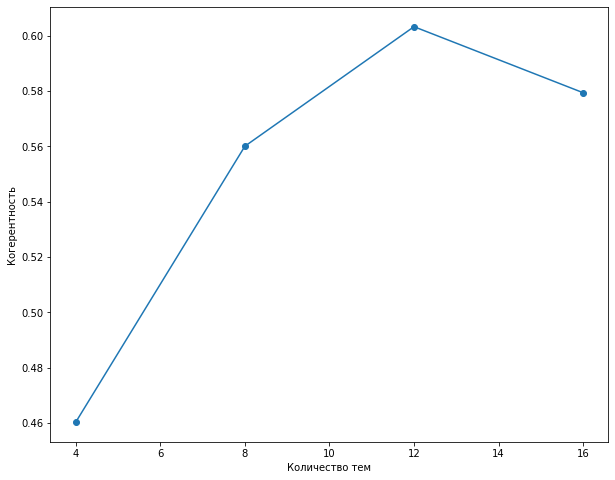

In [334]:
plt.figure(figsize=(10,8))
plt.plot(range(4, 17, 4), coherence_values, marker='o')
plt.xlabel("Количество тем")
plt.ylabel("Когерентность")
plt.show()

In [331]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model_list[3], corpus2, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.048844 -0.101177       1        1  11.991407
10     0.075671 -0.135148       2        1   9.265619
2      0.055458  0.103371       3        1   8.019356
12     0.150204 -0.000948       4        1   7.393358
3      0.085700 -0.017679       5        1   6.650201
11    -0.261149  0.022656       6        1   6.613397
14     0.044673  0.073884       7        1   6.048567
1      0.068768 -0.081342       8        1   5.940743
15     0.054979 -0.006379       9        1   5.768384
6      0.080843  0.101158      10        1   5.458708
0     -0.125241  0.244604      11        1   5.314101
7      0.095517  0.073083      12        1   5.257404
9      0.035910 -0.214386      13        1   5.106265
5     -0.244732 -0.141303      14        1   4.272184
13     0.017176  0.114038      15        1   3.605937
4     -0.182622 -0.034432      16        1   3.294370, topic_info=             Term         Freq        Total Category  logprob  loglift
5574       вакцин  2082.000000  2082.000000  Default  30.0000  30.0000
21        водител  2557.000000  2557.000000  Default  29.0000  29.0000
1863  нижегородск  3351.000000  3351.000000  Default  28.0000  28.0000
433         работ  6541.000000  6541.000000  Default  27.0000  27.0000
4367     вакцинац  2006.000000  2006.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1084        центр   148.488420  1753.989972  Topic16  -5.4493   0.9438
1177    организац   140.637248  1287.342856  Topic16  -5.5036   1.1988
428       проверк   121.973996   479.447994  Topic16  -5.6460   2.0441
810      безопасн   127.911649   899.705019  Topic16  -5.5985   1.4622
199        работа   138.188366  3624.492695  Topic16  -5.5212   0.1461

[1146 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         8  0.923791      авар
0        10  0.033773      авар
0        13  0.011920      авар
0        16  0.029800      авар
493       1  0.028323    август
...     ...       ...       ...
5408      6  0.065830    ярмарк
5408      9  0.050638    ярмарк
5408     11  0.020255    ярмарк
5408     14  0.860850    ярмарк
5466     14  0.965530  ярмарочн

[5341 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 11, 3, 13, 4, 12, 15, 2, 16, 7, 1, 8, 10, 6, 14, 5])

In [335]:
coherence_values[3]

0.5793925593173052

**Выводы:**